# STEP B

In [24]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

def read_image_and_compute_keypoints(object_imgs, scene_imgs, detector):
    imgs_dict = {}

    for name_img in object_imgs:
        img_load = cv2.imread('models/' + name_img + '.jpg', cv2.IMREAD_GRAYSCALE)
        
        """
        # Enlever le centre de l'image
        row = int(img_load.shape[0]/2)
        col = int(img_load.shape[1]/2)
        pour = 0.5
        new_color = 255 # White
        img_load[int(row - row*pour) : int(row + row*pour), int(col - col*pour): int(col + col*pour)] = new_color
        #
        """

        kp, des = detector.detectAndCompute(img_load, None)
        imgs_dict[name_img] = {'kp': kp, 'des': des, 'shape': img_load.shape}

    for name_img in scene_imgs:
        img_load = cv2.imread('scenes/' + name_img + '.png', cv2.IMREAD_GRAYSCALE)
        kp, des = detector.detectAndCompute(img_load, None)
        imgs_dict[name_img] = {'kp': kp, 'des': des, 'shape': img_load.shape}

    return imgs_dict

def matching_and_localize_objects_in_scene(imgs_dict, name_scene_img, ratio_test=0.45):
    all_scene_corners = {}
    all_good ={}
    for name in object_imgs:
        object_des, object_kp = imgs_dict[name]['des'], imgs_dict[name]['kp']
        scene_des, scene_kp = imgs_dict[name_scene_img]['des'], imgs_dict[name_scene_img]['kp']
        
        #-- matching
        matches = matcher.knnMatch(object_des, scene_des, k=2)
    
        #-- store all the good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < ratio_test*n.distance:
                good.append(m)
                
        if len(good) > 30:        
            #-- Get the keypoints from the good matches
            object_good_kp = np.float32([ object_kp[m.queryIdx].pt for m in good ])
            scene_good_kp = np.float32([ scene_kp[m.trainIdx].pt for m in good ])   


            #-- Get the corners of object
            h,w = imgs_dict[name]['shape'][0:2]
            object_corners = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

            #-- Get the homography of object/scene
            H, _ =  cv2.findHomography(object_good_kp, scene_good_kp, cv2.RANSAC, 5.0)

            #-- Get the corners of object in scene
            scene_corners = cv2.perspectiveTransform(object_corners, H)


            all_scene_corners[name] = scene_corners
            all_good[name] = good
        
    return all_scene_corners, all_good

def check_best_color_matches(all_scene_corners, name_scene_img):
    
    scene_img_bgr = cv2.imread('scenes/' + name_scene_img + '.png')
    best_all_scene_corners = {}
    
    for name in all_scene_corners.keys():

        x_min = max(int(np.min(all_scene_corners[name], axis=0)[0][0]), 0)
        y_min = max(int(np.min(all_scene_corners[name], axis=0)[0][1]), 0)
        x_max = int(np.max(all_scene_corners[name], axis=0)[0][0])
        y_max = int(np.max(all_scene_corners[name], axis=0)[0][1])
        
        object_img_bgr = cv2.imread('models/' + name + '.jpg')
        
        object_img_mean_color = object_img_bgr.mean(axis=0).mean(axis=0)
        object_in_scene_img = scene_img_bgr[y_min:y_max,x_min:x_max]
        object_in_scene_img_mean_color = object_in_scene_img.mean(axis=0).mean(axis=0)   
        color_diff = np.sqrt(np.sum([value ** 2 for value in abs(object_img_mean_color - object_in_scene_img_mean_color)]))
        
        #color_diff = (np.sum([value **2 for value in (object_img_mean_color - object_in_scene_img_mean_color)]))/4
        
        if color_diff < 60:
            best_all_scene_corners[name] = all_scene_corners[name]
        
    return best_all_scene_corners

def drawn_object_lines_in_scene(img_scene, best_all_scene_corners):
    for name in best_all_scene_corners.keys():
        scene_corners = best_all_scene_corners[name]
        img_scene = cv2.polylines(img_scene, [np.int32(scene_corners)], 
                                  isClosed=True, color=(0,255,0), thickness=5)
    return img_scene

def print_object_found(best_all_scene_corners):
    for name in best_all_scene_corners.keys():  
        x_min = max(int(np.min(best_all_scene_corners[name], axis=0)[0][0]), 0)
        y_min = max(int(np.min(best_all_scene_corners[name], axis=0)[0][1]), 0)
        x_max = int(np.max(best_all_scene_corners[name], axis=0)[0][0])
        y_max = int(np.max(best_all_scene_corners[name], axis=0)[0][1])
        
        print('Product {} - {} instance/s found:'.format(name, 1))
        print('\tInstance {} position: {}, width: {}px, height: {}px'.format(1, (x_min, y_min), (x_max-x_min), (y_max-y_min)))
    
    print('_' * 80 + '\n')

def stepA():
    
    detector = cv2.SIFT_create()
    FLANN_INDEX_KDTREE = 1

        # Defining parameters for algorithm 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

        # Defining search params.
        # checks=50 specifies the number of times the trees in the index should be recursively traversed.
        # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)

        # Initializing matcher
    matcher = cv2.FlannBasedMatcher(index_params, search_params)
    #matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
    
    imgs_dict = read_image_and_compute_keypoints(object_imgs, scene_imgs, detector)
    
    
    for scene_name in scene_imgs:
        
        all_scene_corners, all_good= matching_and_localize_objects_in_scene(imgs_dict, scene_name)
        
        best_all_scene_corners = check_best_color_matches(all_scene_corners , scene_name)
        
        
        img_scene_rgb = cv2.cvtColor(cv2.imread('scenes/' + scene_name + '.png'), cv2.COLOR_BGR2RGB)
        img_scene_rgb = drawn_object_lines_in_scene(img_scene_rgb, best_all_scene_corners)

        
        print('Scene {} :'.format(scene_name))
        plt.imshow(img_scene_rgb)
        plt.show()
        print_object_found(best_all_scene_corners)

In [25]:
#-- bank of image step B
object_imgs = ['0', '1', '11', '19', '24', '25', '26']
#object_imgs = ['0', '11']
scene_imgs = ['m1', 'm2', 'm3', 'm4', 'm5']

# Initialize the SIFT detector and the FLANNBASED Matcher
detector = cv2.SIFT_create()
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)

In [26]:
imgs_dict = read_image_and_compute_keypoints(object_imgs, scene_imgs, detector)

In [27]:
imgs_dict

{'0': {'kp': [<KeyPoint 0x7f97075effc0>,
   <KeyPoint 0x7f972fa02ae0>,
   <KeyPoint 0x7f972fa02f30>,
   <KeyPoint 0x7f97061adbd0>,
   <KeyPoint 0x7f97061a6150>,
   <KeyPoint 0x7f972e1d03c0>,
   <KeyPoint 0x7f9707670630>,
   <KeyPoint 0x7f9707670870>,
   <KeyPoint 0x7f97076f3540>,
   <KeyPoint 0x7f97076f3630>,
   <KeyPoint 0x7f97076f3600>,
   <KeyPoint 0x7f97076f3a20>,
   <KeyPoint 0x7f97076f3480>,
   <KeyPoint 0x7f97076f3a50>,
   <KeyPoint 0x7f97076f3060>,
   <KeyPoint 0x7f97076f3990>,
   <KeyPoint 0x7f97076f3f30>,
   <KeyPoint 0x7f97076f3f90>,
   <KeyPoint 0x7f972e8ddb40>,
   <KeyPoint 0x7f972df36b10>,
   <KeyPoint 0x7f9707a72180>,
   <KeyPoint 0x7f9707a721b0>,
   <KeyPoint 0x7f9707a72150>,
   <KeyPoint 0x7f9707a720f0>,
   <KeyPoint 0x7f9707a72090>,
   <KeyPoint 0x7f9707a721e0>,
   <KeyPoint 0x7f9707a722d0>,
   <KeyPoint 0x7f9707a72420>,
   <KeyPoint 0x7f9707a72390>,
   <KeyPoint 0x7f9707a72240>,
   <KeyPoint 0x7f9707a723f0>,
   <KeyPoint 0x7f9707a72300>,
   <KeyPoint 0x7f9707a72480>,

In [40]:
def matching_and_store_good_matches(imgs_dict, name_scene_img, ratio_test = 0.5):
    all_good_matches = {}
    all_good_keypoints = {}
    for name in object_imgs:
        object_des, object_kp = imgs_dict[name]['des'], imgs_dict[name]['kp']
        scene_des, scene_kp = imgs_dict[name_scene_img]['des'], imgs_dict[name_scene_img]['kp']

        #-- matching
        matches = matcher.knnMatch(object_des, scene_des, k=2)

        #-- store all the good matches as per Lowe's ratio test.

        good = []
        for m,n in matches:
            if m.distance < ratio_test*n.distance:
                good.append(m)

        good_kp = {}
        for m in good:
            good_kp[scene_kp[m.trainIdx]] = object_kp[m.queryIdx]

    
    #-- put in the dict of matches of all images if there are more matches than the threshold
    
        if len(good) > 50:
            all_good_matches[name] = good
            all_good_keypoints[name] = good_kp
    
    return all_good_matches, all_good_keypoints

In [41]:
all_good_matches, all_good_keypoints = matching_and_store_good_matches(imgs_dict, 'm1')
all_good_keypoints

{'0': {<KeyPoint 0x7f96f602ea80>: <KeyPoint 0x7f9707c26360>,
  <KeyPoint 0x7f96f602f8d0>: <KeyPoint 0x7f9707c336c0>,
  <KeyPoint 0x7f96f602fb10>: <KeyPoint 0x7f9707c38c00>,
  <KeyPoint 0x7f96f602fd50>: <KeyPoint 0x7f9707c36c30>,
  <KeyPoint 0x7f96f602fe40>: <KeyPoint 0x7f9707c3d990>,
  <KeyPoint 0x7f96f60301e0>: <KeyPoint 0x7f9707c3bab0>,
  <KeyPoint 0x7f96f60305a0>: <KeyPoint 0x7f9707a5dc00>,
  <KeyPoint 0x7f96f602f930>: <KeyPoint 0x7f9707a5a330>,
  <KeyPoint 0x7f96f60307b0>: <KeyPoint 0x7f9707a671b0>,
  <KeyPoint 0x7f96f6030210>: <KeyPoint 0x7f9707a6d090>,
  <KeyPoint 0x7f96f6031fc0>: <KeyPoint 0x7f9707a6d240>,
  <KeyPoint 0x7f96f6032030>: <KeyPoint 0x7f9707a6d120>,
  <KeyPoint 0x7f96f6030ba0>: <KeyPoint 0x7f9707a6d510>,
  <KeyPoint 0x7f96f6030ae0>: <KeyPoint 0x7f9707a6d660>,
  <KeyPoint 0x7f96f6032ed0>: <KeyPoint 0x7f9707a8f450>,
  <KeyPoint 0x7f96f60338d0>: <KeyPoint 0x7f9707a92240>,
  <KeyPoint 0x7f96f6033900>: <KeyPoint 0x7f9707a922a0>,
  <KeyPoint 0x7f96f6033e70>: <KeyPoint 0x7f

In [42]:
def compute_barycenter_of_found_object_keypoints(all_good_keypoints):
    """
    Based on good matches and it's associated keypoints, this method compute the barycenter these keypoints
    """
    all_barycenter = {}
    for name in all_good_keypoints.keys():
        good_kp = all_good_keypoints[name]
        object_xc = np.mean([ kp.pt[0] for kp in good_kp.values() ], dtype='float')
        object_yc = np.mean([ kp.pt[1] for kp in good_kp.values() ], dtype='float')
        
        all_barycenter[name] = (object_xc, object_yc)
        
    return all_barycenter

In [43]:
all_barycenter = compute_barycenter_of_found_object_keypoints(all_good_keypoints)
all_barycenter

{'0': (566.169126226547, 782.7695559237866),
 '24': (142.26060972408374, 245.07557314269397),
 '25': (301.3071089564143, 253.73884131457353),
 '26': (141.1538402877168, 243.55392339557946)}

In [44]:
def compute_GHT_for_all_matches(all_good_keypoints, all_barycenter):
    """
    Based on keypoints and its barycenter associated, this method compute the Generalized Hough Transform 
    for each model image
    """
    
    all_hough_space = {}
    for name in all_good_keypoints.keys():
    
        hough_space = {}
        good_kp = all_good_keypoints[name]
        object_xc, object_yc = all_barycenter[name]

        for scene_kp, object_kp in good_kp.items():


            entry = {}

            v = ((object_xc - object_kp.pt[0]), (object_yc - object_kp.pt[1]))
            ratio_of_size = scene_kp.size / object_kp.size
            relative_angle = scene_kp.angle - object_kp.angle
            x_c = scene_kp.pt[0] + ratio_of_size * (np.cos(relative_angle) * v[0] - np.sin(relative_angle) * v[1])
            y_c = scene_kp.pt[1] + ratio_of_size * (np.sin(relative_angle) * v[0] + np.cos(relative_angle) * v[1])

            entry['x_c'] = x_c
            entry['y_c'] = y_c
            entry['ratio_of_size'] = ratio_of_size
            entry['relative_angle'] = relative_angle

            hough_space[(object_kp, scene_kp)] = entry
        
        all_hough_space[name] = hough_space
        
    return all_hough_space

In [45]:
all_hough_space = compute_GHT_for_all_matches(all_good_keypoints, all_barycenter)
all_hough_space

{'0': {(<KeyPoint 0x7f9707c26360>,
   <KeyPoint 0x7f96f602ea80>): {'x_c': 867.853248166294, 'y_c': 127.86972181425438, 'ratio_of_size': 0.20894468466288907, 'relative_angle': -0.628265380859375},
  (<KeyPoint 0x7f9707c336c0>,
   <KeyPoint 0x7f96f602f8d0>): {'x_c': 874.8858298490336, 'y_c': 398.5478974879758, 'ratio_of_size': 0.2172305697350106, 'relative_angle': 2.04876708984375},
  (<KeyPoint 0x7f9707c38c00>,
   <KeyPoint 0x7f96f602fb10>): {'x_c': 766.5764882187398, 'y_c': 364.25445190484174, 'ratio_of_size': 0.22918312328026508, 'relative_angle': 2.8911285400390625},
  (<KeyPoint 0x7f9707c36c30>,
   <KeyPoint 0x7f96f602fd50>): {'x_c': 867.3147764587228, 'y_c': 137.4156856205452, 'ratio_of_size': 0.22919689096798046, 'relative_angle': -0.62744140625},
  (<KeyPoint 0x7f9707c3d990>,
   <KeyPoint 0x7f96f602fe40>): {'x_c': 936.6015428560917, 'y_c': 193.08113517264619, 'ratio_of_size': 0.23109836047132826, 'relative_angle': 6.4665374755859375},
  (<KeyPoint 0x7f9707c3bab0>,
   <KeyPoint 0x

In [46]:
def compute_bins_for_one_scene(all_hough_space, imgs_dict, img_scene_name):
    """
    This method use the GHT to find bins values for each model image and its associate keypoints
    from good matches
    """
    
    ANGLE = 7
    all_values_of_bins = {}
    
    for name in all_hough_space.keys():

        list_ratio_of_size = [ entry['ratio_of_size'] for entry in all_hough_space[name].values() ]
        ratio_of_size_global = np.median(list_ratio_of_size)

        list_relative_angle = [entry['relative_angle'] for entry in all_hough_space[name].values()]


        object_shape = imgs_dict[name]['shape']
        scene_shape = imgs_dict[img_scene_name]['shape']

        x_bin_size = ratio_of_size_global * object_shape[1] * 0.25
        y_bin_size = ratio_of_size_global * object_shape[0] * 0.25
        x_bins = int(np.ceil(scene_shape[1] / x_bin_size) + 2)
        y_bins = int(np.ceil(scene_shape[0] / y_bin_size) + 2)
        x_min = scene_shape[1] / 2 - x_bins / 2 * x_bin_size
        y_min = scene_shape[0] / 2 - y_bins / 2 * y_bin_size

        angle_bin_size = np.std(list_relative_angle) * 0.1
        angle_bin_center = np.mean(list_relative_angle)
        angle_min = angle_bin_center - ANGLE / 2 * angle_bin_size
        angle_max = angle_bin_center + ANGLE / 2 * angle_bin_size

        scale_bin_size = np.std(list_ratio_of_size) * 0.1
        scale_bin_center = np.mean(list_ratio_of_size)
        scale_min = 0 
        scale_max = scale_bin_center * 2 
        scale_bins = int((scale_max - scale_min) / scale_bin_size)

        bins_values = {}
        bins_values['x_bins'] = x_bins
        bins_values['y_bins'] = y_bins
        bins_values['x_min'] = x_min
        bins_values['y_min'] = y_min
        bins_values['x_bin_size'] = x_bin_size
        bins_values['y_bin_size'] = y_bin_size
        bins_values['scale_bins'] = scale_bins
        bins_values['scale_min'] = scale_min
        bins_values['scale_bin_size'] = scale_bin_size
        bins_values['angle_min'] = angle_min
        bins_values['angle_bin_size'] = angle_bin_size  

        all_values_of_bins[name] = bins_values
    
    return all_values_of_bins

In [47]:
all_values_of_bins = compute_bins_for_one_scene(all_hough_space, imgs_dict, 'm1')
all_values_of_bins

{'0': {'x_bins': 25,
  'y_bins': 8,
  'x_min': -80.30844531007233,
  'y_min': -110.67018438808572,
  'x_bin_size': 63.38467562480579,
  'y_bin_size': 86.04254609702143,
  'scale_bins': 17,
  'scale_min': 0,
  'scale_bin_size': 0.04137224388079132,
  'angle_min': -5.387275823946089,
  'angle_bin_size': 5.2579599764014855},
 '24': {'x_bins': 19,
  'y_bins': 6,
  'x_min': -105.65574753710018,
  'y_min': -136.59681204310846,
  'x_bin_size': 86.06902605653686,
  'y_bin_size': 123.3656040143695,
  'scale_bins': 204,
  'scale_min': 0,
  'scale_bin_size': 0.012651748288754497,
  'angle_min': -15.763093095352374,
  'angle_bin_size': 6.221303279042916},
 '25': {'x_bins': 20,
  'y_bins': 7,
  'x_min': -103.95173802020281,
  'y_min': -149.5173452588952,
  'x_bin_size': 81.59517380202028,
  'y_bin_size': 109.4335272168272,
  'scale_bins': 141,
  'scale_min': 0,
  'scale_bin_size': 0.007914156002580641,
  'angle_min': -18.09023286917285,
  'angle_bin_size': 4.1205695073334265},
 '26': {'x_bins': 19,

In [48]:
def voting(all_values_of_bins, all_hough_space):
    """
    This method attributes 16 bins to each point in the hough space based on keypoints of good matches and 
    GHT of these keypoints
    """
    
    ANGLE = 7
    
    all_votes = {}
    all_accumulator = {}
    
    for name in all_hough_space.keys():
        
        bins_values = all_values_of_bins[name]
        hough_space = all_hough_space[name]
        
        accumulator = np.zeros((bins_values['x_bins'], bins_values['y_bins'], ANGLE, bins_values['scale_bins']))

        votes = {}

        for kps, v in hough_space.items():
            try:
                for x in range(0, 2):
                    for y in range(0, 2):
                        for z in range(0, 2):
                            for w in range(0, 2):                
                                i = int(np.floor((v['x_c'] - bins_values['x_min'] + (x - 1 / 2) * bins_values['x_bin_size']) / bins_values['x_bin_size']))
                                j = int(np.floor((v['y_c'] - bins_values['y_min'] + (y - 1 / 2) * bins_values['y_bin_size']) / bins_values['y_bin_size']))
                                k = int(np.floor((v['relative_angle'] - bins_values['angle_min'] + (z - 1 / 2) * bins_values['angle_bin_size']) / bins_values['angle_bin_size']))
                                l = int(np.floor((v['ratio_of_size'] - bins_values['scale_min'] + (w - 1 / 2) * bins_values['scale_bin_size']) / bins_values['scale_bin_size']))
                                if i >= 0 and j >= 0 and k >= 0 and l >= 0:
                                    accumulator[i, j, k, l] += 1
                                    votes[(i, j, k, l)] = votes.get((i, j, k, l), [])
                                    votes[(i, j, k, l)].append(kps)
            except: pass
            
        all_votes[name] = votes
        all_accumulator[name] = accumulator
        
    return all_votes, all_accumulator

In [49]:
all_votes, all_accumulator = voting(all_values_of_bins, all_hough_space)
all_votes

{'0': {(14, 2, 0, 4): [(<KeyPoint 0x7f9707c26360>, <KeyPoint 0x7f96f602ea80>)],
  (14, 2, 0, 5): [(<KeyPoint 0x7f9707c26360>, <KeyPoint 0x7f96f602ea80>),
   (<KeyPoint 0x7f9707c36c30>, <KeyPoint 0x7f96f602fd50>)],
  (14, 2, 1, 4): [(<KeyPoint 0x7f9707c26360>, <KeyPoint 0x7f96f602ea80>),
   (<KeyPoint 0x7f9707c3bab0>, <KeyPoint 0x7f96f60301e0>)],
  (14, 2, 1, 5): [(<KeyPoint 0x7f9707c26360>, <KeyPoint 0x7f96f602ea80>),
   (<KeyPoint 0x7f9707c36c30>, <KeyPoint 0x7f96f602fd50>),
   (<KeyPoint 0x7f9707c3bab0>, <KeyPoint 0x7f96f60301e0>)],
  (14, 3, 0, 4): [(<KeyPoint 0x7f9707c26360>, <KeyPoint 0x7f96f602ea80>),
   (<KeyPoint 0x7f9707a6d240>, <KeyPoint 0x7f96f6031fc0>),
   (<KeyPoint 0x7f9707a6d120>, <KeyPoint 0x7f96f6032030>),
   (<KeyPoint 0x7f9707a6d510>, <KeyPoint 0x7f96f6030ba0>)],
  (14, 3, 0, 5): [(<KeyPoint 0x7f9707c26360>, <KeyPoint 0x7f96f602ea80>),
   (<KeyPoint 0x7f9707c36c30>, <KeyPoint 0x7f96f602fd50>),
   (<KeyPoint 0x7f9707a6d240>, <KeyPoint 0x7f96f6031fc0>),
   (<KeyPoint 0

In [62]:
import skimage.morphology as sk

# store in a list all the correspondeces between query points and train points that voted for a local maxima 
# the list contains: number of votes that a local maxima bin has received,
#name of query image, list of query and train keypoints which voted for that bin


def compute_correspondences(all_votes, all_accumulator):
    
    all_global_correspondences = {}
    
    for name in all_votes.keys():
    
        mask = sk.local_maxima(all_accumulator[name])
        all_accumulator[name][mask != 1] = 0

        T_Q = 6
        global_correspondences = []

        for b in list(np.argwhere(all_accumulator[name] >= T_Q)): # thresholding the accumulator to come up with few maxima 
            global_correspondences.append([all_accumulator[name][tuple(b)], all_votes[name][tuple(b)]])
            
        all_global_correspondences[name] = global_correspondences
        
    return all_global_correspondences
    

In [63]:
all_global_correspondences = compute_correspondences(all_votes, all_accumulator)
all_global_correspondences

{'0': [[21.0,
   [(<KeyPoint 0x7f9707c3d990>, <KeyPoint 0x7f96f602fe40>),
    (<KeyPoint 0x7f9707a6d660>, <KeyPoint 0x7f96f6030ae0>),
    (<KeyPoint 0x7f9707a8f450>, <KeyPoint 0x7f96f6032ed0>),
    (<KeyPoint 0x7f9707a92240>, <KeyPoint 0x7f96f60338d0>),
    (<KeyPoint 0x7f9707a922a0>, <KeyPoint 0x7f96f6033900>),
    (<KeyPoint 0x7f9707c419c0>, <KeyPoint 0x7f96f6033e70>),
    (<KeyPoint 0x7f9707c48750>, <KeyPoint 0x7f96f6034960>),
    (<KeyPoint 0x7f9707c4e360>, <KeyPoint 0x7f96f6034ed0>),
    (<KeyPoint 0x7f9707c4e390>, <KeyPoint 0x7f96f6034f00>),
    (<KeyPoint 0x7f9707c54150>, <KeyPoint 0x7f96f6035720>),
    (<KeyPoint 0x7f9707c55030>, <KeyPoint 0x7f96f6035810>),
    (<KeyPoint 0x7f9707c550f0>, <KeyPoint 0x7f96f6035780>),
    (<KeyPoint 0x7f9707c58360>, <KeyPoint 0x7f96f6035b70>),
    (<KeyPoint 0x7f9707c58390>, <KeyPoint 0x7f96f6035ba0>),
    (<KeyPoint 0x7f9707c59f60>, <KeyPoint 0x7f96f6035e70>),
    (<KeyPoint 0x7f9707c5d9c0>, <KeyPoint 0x7f96f6036300>),
    (<KeyPoint 0x7f9707c5f

In [64]:
def compute_objects_corners_in_one_scene(all_global_correspondences, scene_name):
    
    all_scene_corners = []
    
    for name in all_global_correspondences.keys():
        h,w = imgs_dict[name]['shape'][0:2]
        object_corners = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

        for i in range(len(all_global_correspondences[name])):
            scene_corners = {}
            keypoints = all_global_correspondences[name][i]
            object_pts = np.float32([kp[0].pt for kp in keypoints[1]]).reshape(-1, 1, 2)
            scene_pts = np.float32([kp[1].pt for kp in keypoints[1]]).reshape(-1, 1, 2)
            H, _ =  cv2.findHomography(object_pts, scene_pts, cv2.RANSAC, 5.0)


            scene_corners[name] = cv2.perspectiveTransform(object_corners, H)
            
            all_scene_corners.append(scene_corners)
    
    return all_scene_corners

In [65]:
all_scene_corners = compute_objects_corners_in_one_scene(all_global_correspondences, 'm1')
all_scene_corners

[{'0': array([[[ 808.6117  ,  -29.160019]],
  
         [[ 837.5794  ,  334.09064 ]],
  
         [[1066.5809  ,  325.42203 ]],
  
         [[1088.2903  ,   -9.239781]]], dtype=float32)},
 {'24': array([[[383.12134 , -26.422234]],
  
         [[384.0046  , 466.01923 ]],
  
         [[720.9238  , 467.9475  ]],
  
         [[712.8211  , -20.058403]]], dtype=float32)},
 {'25': array([[[1112.3209   ,    7.5192986]],
  
         [[1098.7191   ,  455.17203  ]],
  
         [[1415.9548   ,  454.49713  ]],
  
         [[1420.5527   ,   16.122055 ]]], dtype=float32)},
 {'25': array([[[1107.8124   ,    5.5239267]],
  
         [[1103.5159   ,  442.17145  ]],
  
         [[1407.4061   ,  434.76932  ]],
  
         [[1422.5623   ,   16.211287 ]]], dtype=float32)},
 {'26': array([[[ 755.1882  ,  -26.444248]],
  
         [[ 753.7361  ,  465.5135  ]],
  
         [[1083.3683  ,  457.16876 ]],
  
         [[1090.346   ,  -21.255795]]], dtype=float32)},
 {'26': array([[[ 754.6973  ,  -28.156612]],
  


In [66]:
def drawn_object_lines_in_scene(img_scene, all_scene_corners):
    for dic in all_scene_corners:
        for values in dic.values():
            scene_corners = values
            img_scene = cv2.polylines(img_scene, [np.int32(values)], 
                                  isClosed=True, color=(0,255,0), thickness=5)
    return img_scene

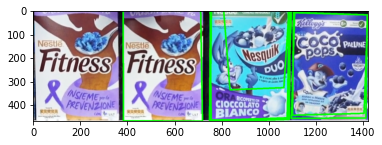

In [67]:
img_scene = cv2.imread('scenes/m1.png')
img_scene = drawn_object_lines_in_scene(img_scene, all_scene_corners)
plt.imshow(img_scene)